In [1]:
import torch
from glob import glob
from ast import literal_eval

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from IPython.core.display import display, HTML
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm

/tmp/ipykernel_2981272/3707511573.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

plt.style.use('dark_background')

display(HTML("<style>"
    + "#notebook { padding-top:0px; } " ""
    + ".container { width:100%; } "
    + ".end_space { min-height:0px; } "
    + "</style>"))

device = 'cuda'

In [3]:
def print_exp_info(exp: dict):
    print(f'model: {exp["model"]} {exp["approach"]}')
    print({k: exp[k] for k in exp if k not in ['logs', 'results', 'knowledge']})

# usage example:  show_exp_images(experiments[0], True)
def show_exp_images(exp: dict, show_origins=False):
    for task in exp['results']:
        cur_images = exp['results'][task]['images']
        fig, axs = plt.subplots(2, 5, figsize=(15, 8))
        fig.suptitle(f'TASK {task} {exp["knowledge"][task]}', fontsize=30)
        for r, row in enumerate(axs):
            for c, cell in enumerate(row):
                idx = r*5 + c
                image = np.zeros((28, 28, 3), dtype=float)
                cell.set_title(cur_images[idx]['label'])
                orig = np.array(cur_images[idx]['original'][0])
                recon = np.array(cur_images[idx]['reconstruction'][0]).clip(0, 1)
                if show_origins:
                    image[:,:,1] = orig
                image[:,:,0] = recon
                image[:,:,2] = recon
                cell.imshow(image)
        plt.show()

In [71]:
def calc_D_L_torch(data: torch.Tensor, sigma=1., approach: str = 'euclidean', **kwargs_approach):
    dist_matrix = ((data[None, ...] - data.unsqueeze(1)) ** 2).sum(-1)
    # compute affinity matrix
    if approach == 'euclidean':
        A = torch.exp(-dist_matrix / (sigma ** 2))
    elif approach == 'knn':
        A = calc_A_knn(dist_matrix, distance=True, k=kwargs_approach['k'], symmetric=True)
    else:
        raise ValueError(f'Approach {approach} not implemented. Use only possibile values.')

    # compute degree matrix
    D = torch.diag(A.sum(1))
    # compute laplacian
    L = D - A
    return A, D, L

def find_eig_torch(laplacian: torch.Tensor):
    eigenvalues, eigenvectors = torch.linalg.eig(laplacian)
    eigenvalues = eigenvalues.to(float)
    eigenvectors = eigenvectors.to(float)
    sorted_indices = torch.argsort(eigenvalues)
    eigenvalues, eigenvectors = eigenvalues[sorted_indices], eigenvectors[:,sorted_indices]
#     print(eigenvalues,'\n'*2 ,eigenvectors)
    return eigenvalues, eigenvectors

def normalize_A_torch(a_m, d_m):
    return torch.sqrt(torch.linalg.inv(d_m)) @ a_m @ torch.sqrt(torch.linalg.inv(d_m))

def dir_energy(data: torch.Tensor, sigma=1, approach: str = 'euclidean', **kwargs_approach):
    A, D, L = calc_D_L_torch(data, sigma, approach=approach, **kwargs_approach)
    eigenvalues, eigenvectors = find_eig_torch(L)
    energy = calc_energy_from_values(eigenvalues)
    return energy, eigenvalues, eigenvectors

def calc_energy_from_values(values: torch.Tensor):
    nsamples = len(values)
    max_value = nsamples * (nsamples - 1)
    dir_energy = values.sum()
    energy_p = dir_energy / max_value
    return energy_p.cpu().item()

def dir_energy_normal(data: torch.Tensor, sigma=1., approach: str = 'euclidean', **kwargs_approach):
    A, D, L = calc_D_L_torch(data, sigma, approach=approach, **kwargs_approach)
    L_norm = torch.eye(A.shape[0]).to(device) - normalize_A_torch(A, D)
    eigenvalues, eigenvectors = find_eig_torch(L_norm)
    nsamples = len(data)
    max_value = nsamples - 1
    dir_energy = eigenvalues.sum()
    energy_p = dir_energy / max_value
    return energy_p.cpu().item(), eigenvalues, eigenvectors

def calc_A_knn(matrix: torch.Tensor, k: int, distance: bool=True, symmetric: bool = True):
    new_A = torch.clone(matrix)
    mask = torch.diag(torch.ones(new_A.shape[0]))
    if distance:
        new_A[mask==1] = +torch.inf
    else:
        new_A[mask==1] = -torch.inf
    final_A = torch.zeros_like(new_A)

    idxes = new_A.topk(k, largest=False if distance else True)[1]
    for i in range(idxes.shape[0]):
        final_A[i, idxes[i,:]] = 1
    if symmetric:
        final_A = ((final_A + final_A.T) > 0).float()
        # final_A = 0.5*(final_A + final_A.T)
    return final_A

def flatten_list(l: List[List[any]]) -> List[any]:
    return [item for line in l for item in line]

def get_knowledge_list(exp: dict):
    knowledge = [k for k in exp['knowledge'].values()]
    for i in range(1, len(knowledge)):
        knowledge[i] = [k for k in knowledge[i] if k not in flatten_list(knowledge[:i])]
    return knowledge

In [33]:
logs_path = 'C:\\Users\\emace\\AImageLab\\SRV-Continual\\results\\canomaly\\logs'
logs_path = '/nas/softechict-nas-2/efrascaroli/canomaly-data/logs'
logs_path = '/nas/softechict-nas-1/rbenaglia/canomaly-data/logs'
# logs_path = '../storage/logs'

In [82]:
exp_dict = {}
environments = []
for log_file in glob(logs_path + '/**rec**/*.pyd', recursive=True):
    print(log_file)
    with open(log_file, 'r') as f:
        props_list = [prop.split('-', 1) for prop in log_file.replace(logs_path, '').split('\\')[1:-1]]
        props = {prop[0]: prop[1] for prop in props_list}
        exps = []
        for i, line in enumerate(f.readlines()):
            try:
                exps.append(literal_eval(line.replace('nan', 'None')))
            except:
                print(f'Unparsed line {i}:\n\t{exps[:-1]}\n-->\t{line}')

        environments.append({'env': props, 'exps': exps})

        exps = {exp['id']: exp for exp in exps}
        exp_dict = {**exp_dict, **exps}

/nas/softechict-nas-1/rbenaglia/canomaly-data/logs/dataset-rec-fmnist/logs.pyd


In [83]:
exp_list = environments[0]['exps']

In [36]:
def show_exp_energies(exp: dict, index=0, sigma=1,):
    print_exp_info(exp)
    model = exp['model']
    app = exp['approach']
    name = model + ' ' + app + ' ' + str(index)
#     sigma = 10 if exp['model'] != 'rec-vae'
    exp_df = pd.DataFrame(columns=['current', 'past'])
    exp_df.columns = pd.MultiIndex.from_product([[name], ['current', 'past']])
    for task_id in exp['results']:
        task_idx = int(task_id)
        task = exp['results'][task_id]
        targets = torch.tensor(task['targets'], device=device)
        latents = torch.tensor(task['latents'], device=device)
        knowledge = [k for k in exp['knowledge'].values()]
        for i in range(1, len(knowledge)):
            knowledge[i] = [k for k in knowledge[i] if k not in flatten_list(knowledge[:i])]

        cur_latents = latents[np.isin(targets.cpu(), knowledge[task_idx])]
        past_latents = latents[np.isin(targets.cpu(), flatten_list(knowledge[:task_idx+1]))]
        # fut_latents = latents[np.isin(targets.cpu(), flatten_list(knowledge[task_idx:]))]
        
        cur_energy = dir_energy(cur_latents, sigma)
        past_energy = dir_energy(past_latents, sigma)
        # tot_energy = dir_energy(latents, sigma)
        exp_df.loc[task_idx, (name, slice(None))] = cur_energy,past_energy # ,tot_energy
        
        print(f'{task_idx}. Task {task_id} ({knowledge[task_idx]})\n'
              f'current:        energy {cur_energy:.4f}     \tmean {cur_latents.mean():.3f} ± {cur_latents.std():.3f}\n'
              f'with past:      energy {past_energy:.4f}    \tmean {past_latents.mean():.3f} ± {past_latents.std():.3f}\n'
#               f'with future:    energy {dir_energy(fut_latents, sigma):.4f}     \tmean {fut_latents.mean():.3f} ± {fut_latents.std():.3f}\n'
#               f'total:          energy {tot_energy:.4f}      \tmean {latents.mean():.3f} ± {latents.std():.3f}'
            )
    return exp_df

In [84]:
sigma = 10
experiments = [x for x in exp_list if 'rec-vae' in x['model']
#                and len(x['results'])>1 
               and x['n_epochs']>1
               and x['optim'] == 'adam'
              ]
total_list = []
for num, exp in enumerate(experiments):    
    print(f'--------------- {num} ---------------\n')
    exp_df = show_exp_energies(exp, num, sigma=sigma)
    print('\n-------------------------\n')
    total_list.append(exp_df)

df_total = pd.concat(total_list, axis=1)

df_total

--------------- 0 ---------------

model: rec-vae continual
{'seed': 1737718091, 'wandb': True, 'dataset': 'rec-fmnist', 'model': 'rec-vae', 'optim': 'adam', 'lr': 0.001, 'scheduler_steps': 2, 'scheduler_gamma': 0.1, 'approach': 'continual', 'batch_size': 64, 'n_epochs': 30, 'latent_space': 32, 'kl_weight': 1.0, 'forward_sample': True, 'normalized_score': False, 'add_rotation': False, 'min_max_rotation': (-15, 15), 'poison_perc': 0, 'id': '63d31e32-45c3-4684-94fc-308dcfa074fb', 'timestamp': '2022-03-17 12:06:47.251205'}


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [11]:
exp = exp_list[0]
figsize = (20, 10)
limit = 100

def show_analysis(exp: dict):
    print_exp_info(exp)
    for task_id in exp['results']:
        task_idx = int(task_id)
        task = exp['results'][task_id]
        targets = torch.tensor(task['targets'], device=device)
        latents = torch.tensor(task['latents'], device=device)
        knowledge = [k for k in exp['knowledge'].values()]
        for i in range(1, len(knowledge)):
            knowledge[i] = [k for k in knowledge[i] if k not in flatten_list(knowledge[:i])]

        cur_latents = latents[np.isin(targets.cpu(), knowledge[task_idx])]
        # past_latents = latents[np.isin(targets.cpu(), flatten_list(knowledge[:task_idx+1]))]
        # fut_latents = latents[np.isin(targets.cpu(), flatten_list(knowledge[task_idx:]))]
        # past_targets = targets[np.isin(targets.cpu(), flatten_list(knowledge[:task_idx+1]))]


        targets_knowledge = targets.clone()
        for num, kn in enumerate(knowledge):
            targets_knowledge[torch.isin(targets, torch.Tensor(kn).to(device))] = num

        fig, ax = plt.subplots(2, 3, figsize=figsize)
        ax = np.array(ax).flatten().tolist()
        A, D, L = calc_D_L_torch(cur_latents, sigma=sigma)
        eigenvalues, eigenvectors = find_eig_torch(L)
        # eigenvalues /= len(cur_latents)
        ax[0].plot(eigenvalues[1:limit].cpu(), '*')
        ax[0].set_title(f'Current E={calc_energy_from_values(eigenvalues)}\nEigenvalues')

        A, D, L = calc_D_L_torch(latents, sigma=sigma)
        print((D.sum(1)-1).mean().item(),(D.sum(1)-1).std().item(), (D.sum(1)-1).min().item(), (D.sum(1)-1).max().item())
        eigenvalues, eigenvectors = find_eig_torch(L)
        # eigenvalues /= len(past_latents)
        # ax[1].plot(eigenvalues[1:limit].cpu(), '*')
        filt_1 = (np.quantile(eigenvectors[:, 1].cpu().numpy(), .99) > eigenvectors[:, 1].cpu().numpy()) & (eigenvectors[:, 1].cpu().numpy() > np.quantile(eigenvectors[:, 1].cpu().numpy(), .01))
        filt_2 = (np.quantile(eigenvectors[:, 2].cpu().numpy(), .99) > eigenvectors[:, 2].cpu().numpy()) & (eigenvectors[:, 1].cpu().numpy() > np.quantile(eigenvectors[:, 2].cpu().numpy(), .01))
        filt_total = filt_1 & filt_2
    #     ax[1].scatter(eigenvectors[filt_total, 1].cpu(), eigenvectors[filt_total, 2].cpu(), c=past_targets[filt_total].cpu())
        ax[1].set_title(f'With Past E={calc_energy_from_values(eigenvalues)}\nTSNE eigenvectors')

        ts = TSNE(n_components=2, random_state=0, perplexity=30)
        tr = ts.fit_transform(eigenvectors[:,:11].cpu().numpy())
    #     ax[1].scatter(tr[:,0], tr[:,1], c=past_targets.cpu())
        data = pd.DataFrame(np.concatenate([tr, targets_knowledge.cpu()[:, None]], axis=1), columns=['dim1','dim2','label'])
        # fig,ax = plt.subplots(figsize=(10,10))
        sns.scatterplot(x='dim1', y='dim2', hue='label', data=data, palette='tab10', ax=ax[1])

        plt.suptitle(f'{task_idx}. Task {task_id} ({knowledge[task_idx]})')
        ts = TSNE(n_components=2, perplexity=30, random_state=0)
        tr = ts.fit_transform(latents.cpu().numpy())
        data = pd.DataFrame(np.concatenate([tr, targets_knowledge.cpu()[:, None]], axis=1), columns=['dim1','dim2','label'])
        # fig,ax = plt.subplots(figsize=(10,10))
        ax[2].set_title(f'TSNE latent space')
        sns.scatterplot(x='dim1', y='dim2', hue='label', data=data, palette='tab10', ax=ax[2])

        centroids = pd.DataFrame(np.concatenate([latents.cpu().numpy(), targets_knowledge.cpu().numpy()[:, None]],1),
        columns=[i for i in range(latents.shape[1])]+['label']).groupby('label').agg([np.mean, np.std])
        arr_centr = centroids.loc[:, (slice(None), 'mean')].values
        dist_matrix = ((arr_centr[None, ...] - np.expand_dims(arr_centr, 1)) ** 2).sum(-1)
        ax[3].set_title(f'Centroids mutual distances')
        ax[4].set_title(f'Centroids standard deviation')
        sns.heatmap(dist_matrix, annot=True, ax = ax[3])
        sns.heatmap(centroids.loc[:, (slice(None), 'std')].mean(1).to_frame(),annot=True,ax=ax[4])


In [12]:
def task_reduction(task: dict, knowledge_list: list, task_max=1000):
    rec_errs = torch.tensor(task['rec_errs'], device=device)
    latents = torch.tensor(task['latents'], device=device)
    targets = torch.tensor(task['targets'], device=device)
    class_quantity = {label: task_max // (len(group)) for group in knowledge_list for label in group}
    index_list = []
    for label in class_quantity:
        idxes = (targets == label).nonzero(as_tuple=True)[0][:class_quantity[label]]
        index_list.append(idxes)
    idxes = torch.cat(index_list)
    print(knowledge_list)
    print(class_quantity)
    print(idxes.shape)
    print([il.shape for il in index_list])
    return rec_errs, latents, targets

print(exp_list[0]['results']['0'].keys())
_, latents, targets = task_reduction(exp_list[0]['results']['0'], get_knowledge_list(exp_list[3]), 250)
latents.shape

dict_keys(['targets', 'rec_errs', 'images', 'latents', 'rec_mean'])


IndexError: list index out of range

In [74]:
def task_reduction(task: dict, knowledge_list: list, task_max=1000):
    rec_errs = torch.tensor(task['rec_errs'], device=device)
    latents = torch.tensor(task['latents'], device=device)
    targets = torch.tensor(task['targets'], device=device)
    logvars = torch.tensor(task['logvars'], device=device) if 'logvars' in task else None
    class_quantity = {label: task_max // (len(group)) for group in knowledge_list for label in group}
    index_list = []
    for label in class_quantity:
        idxes = (targets == label).nonzero(as_tuple=True)[0][:class_quantity[label]]
        index_list.append(idxes)
    idxes = torch.cat(index_list)
    rec_errs = rec_errs[idxes]
    targets = targets[idxes]
    latents = latents[idxes]
    logvars = logvars[idxes] if logvars is not None else None
    return rec_errs, latents, targets, logvars

# rec_errs, latents, targets, logvars = task_reduction(exp_list[0]['results']['0'], get_knowledge_list(exp_list[3]), 250)

In [79]:
def exp_evolution(exp: dict):
    print('Experiment')
    print_exp_info(exp)
    nrows = 7
    ncols = len(exp['results'])
    figsize = (5*ncols, 5*nrows+5)
    limit = 100
    sigma = 1
    k = 50

    fig, ax = plt.subplots(nrows, ncols, figsize=figsize)
    # ax = ax.flat
    plt.suptitle(f'Evolution {exp["model"]} {exp["approach"]}')
    pbar = tqdm(desc=f'Coputing', total=nrows*ncols, leave=False)

    knowledge = [k for k in exp['knowledge'].values()]
    for i in range(1, len(knowledge)):
        knowledge[i] = [k for k in knowledge[i] if k not in flatten_list(knowledge[:i])]

    for task_id in exp['results']:
        task_idx = int(task_id)
        task = exp['results'][task_id]
        rec_errs, latents, targets, logvars = task_reduction(task, knowledge, 250)
        # targets = torch.tensor(task['targets'], device=device)
        # latents = torch.tensor(task['latents'], device=device)

        cur_latents = latents[np.isin(targets.cpu(), knowledge[task_idx])]
        past_latents = latents[np.isin(targets.cpu(), flatten_list(knowledge[:task_idx+1]))]

        first_latents = latents[np.isin(targets.cpu(), knowledge[0])]
        ax_idx = 0
        targets_knowledge = targets.clone()
        for num, kn in enumerate(knowledge):
            targets_knowledge[torch.isin(targets, torch.Tensor(kn).to(device))] = num


        energy, eigenvalues, eigenvectors = dir_energy(cur_latents, sigma=sigma, approach='knn', k=k)
        ax[ax_idx][task_idx].plot(eigenvalues[:limit].cpu(), '*')
        ax[ax_idx][task_idx].set_title(f'{task_idx}. Task {task_id} ({knowledge[task_idx]})'
                        f'\nCurrent first {limit} Eigenvalues'
                        f'\nenergy: {energy:.4f}')
        # ax[ax_idx][task_idx].set_ylim([0, 1])
        ax_idx += 1
        pbar.update()

        energy, eigenvalues, eigenvectors = dir_energy(past_latents, sigma=sigma,  approach='knn', k=k)
        ax[ax_idx][task_idx].plot(eigenvalues[:limit].cpu(), '*')
        ax[ax_idx][task_idx].set_title(f'Past first {limit} Eigenvalues'
                                       f'\nenergy: {energy:.4f}')
        # ax[ax_idx][task_idx].set_ylim([0, 1])
        ax_idx += 1
        pbar.update()

        energy, eigenvalues, eigenvectors = dir_energy(first_latents, sigma=sigma,  approach='knn', k=k,)
        ax[ax_idx][task_idx].plot(eigenvalues[:limit].cpu(), '*')
        ax[ax_idx][task_idx].set_title(f'Task 0 first {limit} Norm Eigenvalues'
                                       f'\nenergy: {energy:.4f}')
        # ax[ax_idx][task_idx].set_ylim([0, 1])
        ax_idx += 1
        pbar.update()

        # A, D, L = calc_D_L_torch(latents, sigma=sigma)
        # eigenvalues, eigenvectors = find_eig_torch(L)
        # ev_limit = 11
        # ts = TSNE(n_components=2, random_state=0, perplexity=30, init='random', learning_rate='auto')
        # tr = ts.fit_transform(eigenvectors[:,:ev_limit].cpu().numpy())
        # data = pd.DataFrame(np.concatenate([tr, targets_knowledge.cpu()[:, None]], axis=1), columns=['dim1','dim2','label'])
        # sns.scatterplot(x='dim1', y='dim2', hue='label', data=data, palette='tab10', ax=ax[ax_idx])
        # ax[ax_idx].set_title(f'TSNE first {ev_limit} eigenvectors')
        # ax_idx += 1
        # pbar.update()
        #
        # ev_limit = 5
        # ts = TSNE(n_components=2, random_state=0, perplexity=30, init='random', learning_rate='auto')
        # tr = ts.fit_transform(eigenvectors[:,:ev_limit].cpu().numpy())
        # data = pd.DataFrame(np.concatenate([tr, targets_knowledge.cpu()[:, None]], axis=1), columns=['dim1','dim2','label'])
        # sns.scatterplot(x='dim1', y='dim2', hue='label', data=data, palette='tab10', ax=ax[ax_idx])
        # ax[ax_idx].set_title(f'TSNE first {ev_limit} eigenvectors')
        # ax_idx += 1
        # pbar.update()
        #
        # ts = TSNE(n_components=2, random_state=0, perplexity=30, init='random', learning_rate='auto')
        # tr = ts.fit_transform(latents.cpu().numpy())
        # data = pd.DataFrame(np.concatenate([tr, targets_knowledge.cpu()[:, None]], axis=1), columns=['dim1','dim2','label'])
        # ax[ax_idx].set_title(f'TSNE latent space')
        # sns.scatterplot(x='dim1', y='dim2', hue='label', data=data, palette='tab10', ax=ax[ax_idx])
        # ax_idx += 1
        # pbar.update()

        centroids = pd.DataFrame(np.concatenate([latents.cpu().numpy(), targets_knowledge.cpu().numpy()[:, None]],1),
                                 columns=[i for i in range(latents.shape[1])]+['label']).groupby('label').agg([np.mean, np.std])
        arr_centr = centroids.loc[:, (slice(None), 'mean')].values
        dist_matrix = ((arr_centr[None, ...] - np.expand_dims(arr_centr, 1)) ** 2).sum(-1)
        ax[ax_idx][task_idx].set_title(f'Centroids mutual distances')
        sns.heatmap(dist_matrix, annot=True, ax = ax[ax_idx][task_idx])
        ax_idx += 1
        pbar.update()

    pbar.clear()
    pbar.close()
    plt.show()

Experiment
model: rec-vae continual
{'seed': 1737718091, 'wandb': True, 'dataset': 'rec-fmnist', 'model': 'rec-vae', 'optim': 'adam', 'lr': 0.001, 'scheduler_steps': 2, 'scheduler_gamma': 0.1, 'approach': 'continual', 'batch_size': 64, 'n_epochs': 30, 'latent_space': 32, 'kl_weight': 1.0, 'forward_sample': True, 'normalized_score': False, 'add_rotation': False, 'min_max_rotation': (-15, 15), 'poison_perc': 0, 'id': '63d31e32-45c3-4684-94fc-308dcfa074fb', 'timestamp': '2022-03-17 12:06:47.251205'}


Coputing:   0%|          | 0/28 [00:00<?, ?it/s]

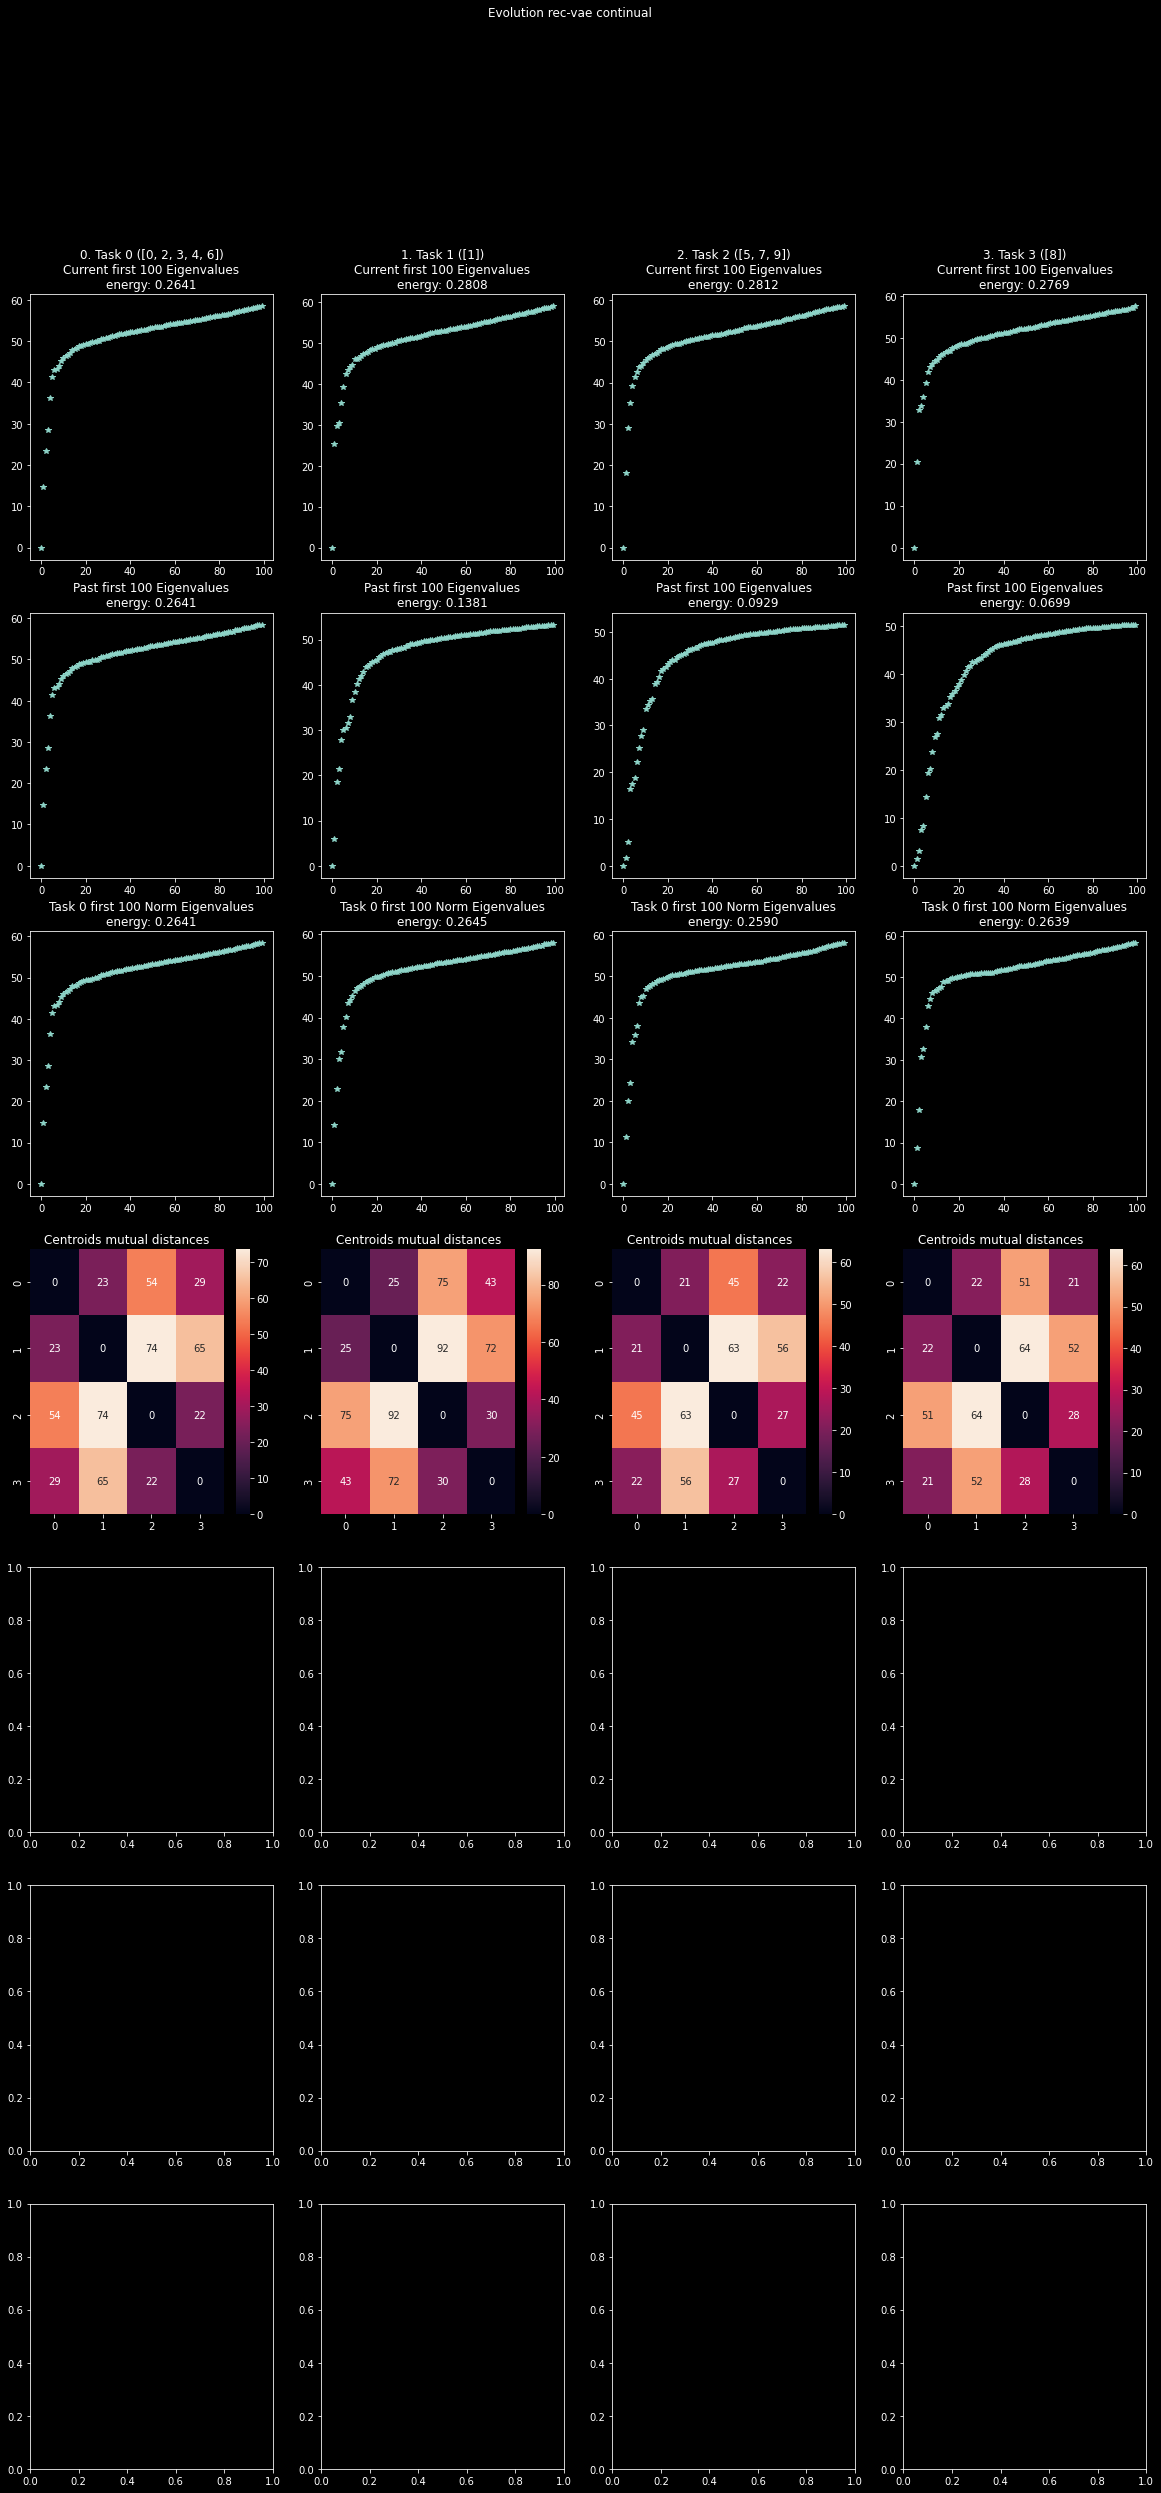

Experiment
model: rec-vae joint
{'seed': 1565878936, 'wandb': True, 'dataset': 'rec-fmnist', 'model': 'rec-vae', 'optim': 'adam', 'lr': 0.001, 'scheduler_steps': 2, 'scheduler_gamma': 0.1, 'approach': 'joint', 'batch_size': 64, 'n_epochs': 30, 'latent_space': 32, 'kl_weight': 1.0, 'forward_sample': True, 'normalized_score': False, 'add_rotation': False, 'min_max_rotation': (-15, 15), 'poison_perc': 0, 'per_task': True, 'id': '82ccd192-1587-4d11-8782-d640f52f738a', 'timestamp': '2022-03-17 17:10:26.365602'}


Coputing:   0%|          | 0/28 [00:00<?, ?it/s]

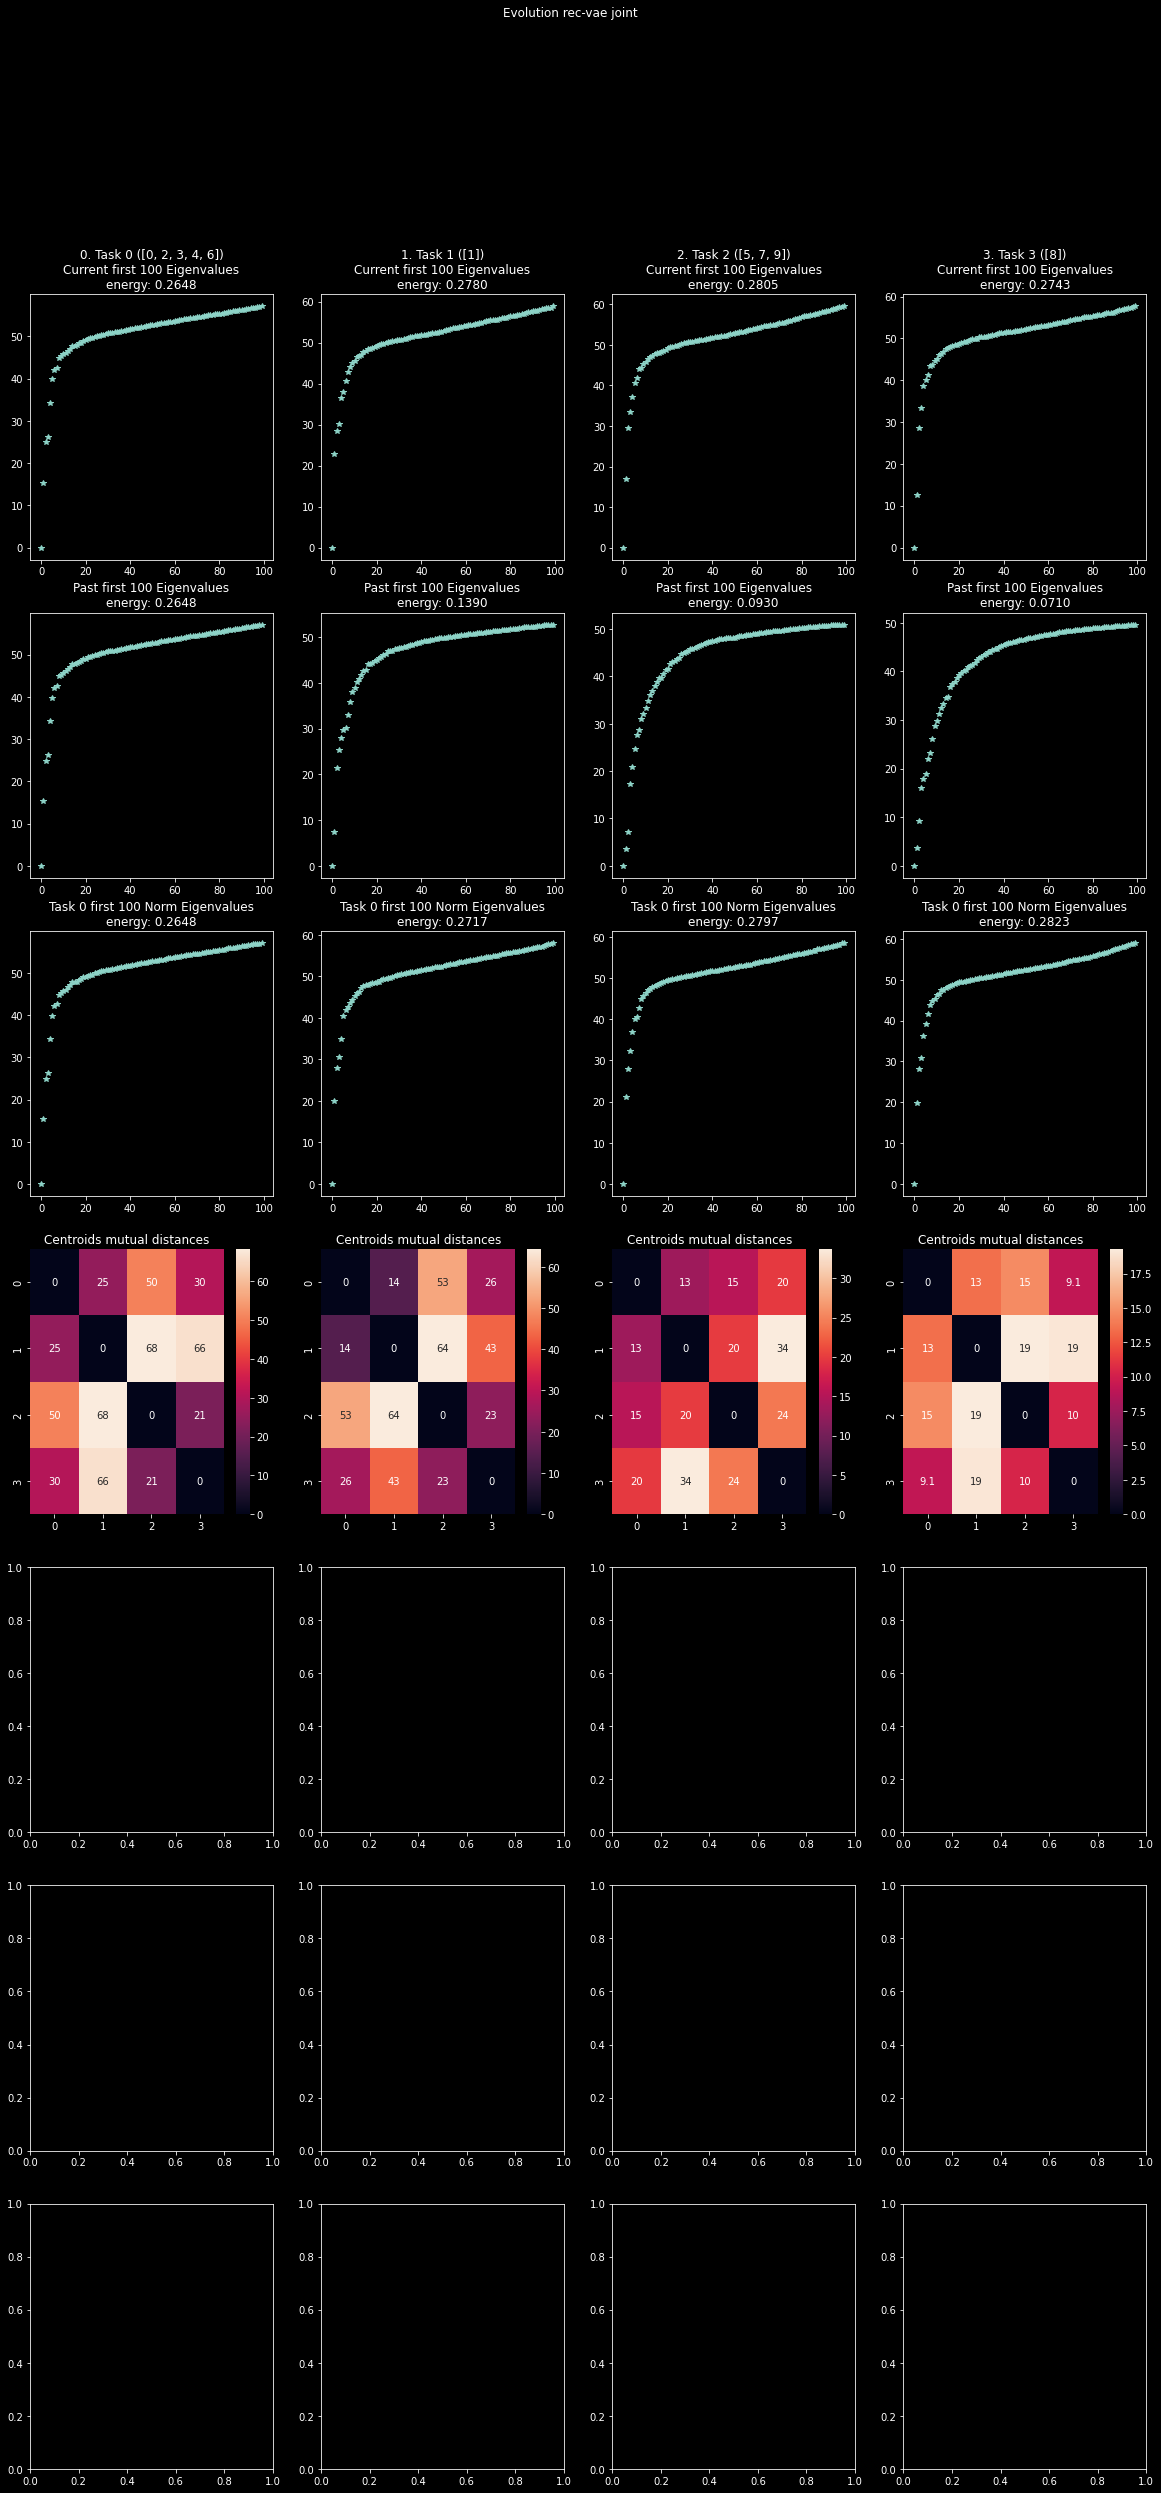

In [86]:
# exp_evolution(exp_list[0])
exp_evolution(exp_list[0])
exp_evolution(exp_list[2])

In [ ]:
exp_evolution(exp_list[2])

In [ ]:
latents = torch.tensor(exp_list[2]['results']['0']['latents'], device=device)
energy, neigenvalues, neigenvectors = dir_energy_normal(latents, sigma=3)
A, D, L = calc_D_L_torch(latents, sigma=10)
eigenvalues, eigenvectors = find_eig_torch(L)

In [ ]:
for i in range(10):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    plt.suptitle(f'Eigenvector {i}')
    ax[0].plot(eigenvectors[:, i].cpu(), '*')
    ax[0].set_title(f'Positives: {(eigenvectors[:, i] > 0).sum()}')
    ax[0].set_ylim([-1.1, 1.1])
    ax[1].plot(neigenvectors[:, i].cpu(), '*')
    ax[1].set_title(f'Positives: {(neigenvectors[:, i] > 0).sum()}')
    plt.show()

In [ ]:
def compare_exps(exps: list[dict]):
    print('Comparing experiments:')
    for exp in exps:
        print_exp_info(exp)
    nrows = 6
    figsize = (5*len(exps), 5*nrows+5)
    limit = 100

    knowledge = [k for k in exps[0]['knowledge'].values()]
    for i in range(1, len(knowledge)):
        knowledge[i] = [k for k in knowledge[i] if k not in flatten_list(knowledge[:i])]
    for task_id in exps[0]['results']:
        task_idx = int(task_id)

        fig, ax = plt.subplots(nrows, len(exps), figsize=figsize)
        plt.suptitle(f'{task_idx}. Task {task_id} ({knowledge[task_idx]})')
        pbar = tqdm(desc=f'Task {task_id}', total=nrows*len(exps), leave=False)

        for exp_idx, exp in enumerate(exps):
            task = exp['results'][task_id]
            targets = torch.tensor(task['targets'], device=device)
            latents = torch.tensor(task['latents'], device=device)

            cur_latents = latents[np.isin(targets.cpu(), knowledge[task_idx])]
            past_latents = latents[np.isin(targets.cpu(), flatten_list(knowledge[:task_idx+1]))]

            targets_knowledge = targets.clone()
            for num, kn in enumerate(knowledge):
                targets_knowledge[torch.isin(targets, torch.Tensor(kn).to(device))] = num

            ax_idx = 0
            ax[ax_idx][exp_idx].set_title(f'{exp["model"]} {exp["approach"]}'
                            f'\nCurrent E={dir_energy(cur_latents, sigma)}'
                            f'\nPast E={dir_energy(past_latents, sigma)}\n'
                            f'\nCurrent first {limit} Eigenvalues')
            A, D, L = calc_D_L_torch(cur_latents, sigma=sigma)
            eigenvalues, eigenvectors = find_eig_torch(L)
            ax[ax_idx][exp_idx].plot(eigenvalues[1:limit].cpu(), '*')
            ax_idx += 1
            pbar.update()

            A, D, L = calc_D_L_torch(past_latents, sigma=sigma)
            eigenvalues, eigenvectors = find_eig_torch(L)
            ax[ax_idx][exp_idx].plot(eigenvalues[1:limit].cpu(), '*')
            ax[ax_idx][exp_idx].set_title(f'Past first {limit} Eigenvalues')
            ax_idx += 1
            pbar.update()

            A, D, L = calc_D_L_torch(latents, sigma=sigma)
            eigenvalues, eigenvectors = find_eig_torch(L)
            ev_limit = 11
            ts = TSNE(n_components=2, random_state=0, perplexity=30, init='random', learning_rate='auto')
            tr = ts.fit_transform(eigenvectors[:,:ev_limit].cpu().numpy())
            data = pd.DataFrame(np.concatenate([tr, targets_knowledge.cpu()[:, None]], axis=1), columns=['dim1','dim2','label'])
            sns.scatterplot(x='dim1', y='dim2', hue='label', data=data, palette='tab10', ax=ax[ax_idx][exp_idx])
            ax[ax_idx][exp_idx].set_title(f'TSNE first {ev_limit} eigenvectors')
            ax_idx += 1
            pbar.update()

            ev_limit = 5
            ts = TSNE(n_components=2, random_state=0, perplexity=30, init='random', learning_rate='auto')
            tr = ts.fit_transform(eigenvectors[:,:ev_limit].cpu().numpy())
            data = pd.DataFrame(np.concatenate([tr, targets_knowledge.cpu()[:, None]], axis=1), columns=['dim1','dim2','label'])
            sns.scatterplot(x='dim1', y='dim2', hue='label', data=data, palette='tab10', ax=ax[ax_idx][exp_idx])
            ax[ax_idx][exp_idx].set_title(f'TSNE first {ev_limit} eigenvectors')
            ax_idx += 1
            pbar.update()

            ts = TSNE(n_components=2, random_state=0, perplexity=30, init='random', learning_rate='auto')
            tr = ts.fit_transform(latents.cpu().numpy())
            data = pd.DataFrame(np.concatenate([tr, targets_knowledge.cpu()[:, None]], axis=1), columns=['dim1','dim2','label'])
            ax[ax_idx][exp_idx].set_title(f'TSNE latent space')
            sns.scatterplot(x='dim1', y='dim2', hue='label', data=data, palette='tab10', ax=ax[ax_idx][exp_idx])
            ax_idx += 1
            pbar.update()

            centroids = pd.DataFrame(np.concatenate([latents.cpu().numpy(), targets_knowledge.cpu().numpy()[:, None]],1),
                                     columns=[i for i in range(latents.shape[1])]+['label']).groupby('label').agg([np.mean, np.std])
            arr_centr = centroids.loc[:, (slice(None), 'mean')].values
            dist_matrix = ((arr_centr[None, ...] - np.expand_dims(arr_centr, 1)) ** 2).sum(-1)
            ax[ax_idx][exp_idx].set_title(f'Centroids mutual distances')
            sns.heatmap(dist_matrix, annot=True, ax = ax[ax_idx][exp_idx])
            ax_idx += 1
            pbar.update()
            # ax[ax_idx][exp_idx].set_title(f'Centroids standard deviation')
            # sns.heatmap(centroids.loc[:, (slice(None), 'std')].mean(1).to_frame(),annot=True,ax=ax[ax_idx][exp_idx])

        pbar.close()
        pbar.clear()
        plt.show()

In [ ]:
idx_to_cmp = [2, 3]
if len(idx_to_cmp) > 0:
    compare_exps([exp_list[idx] for idx in idx_to_cmp])

In [ ]:
idx_to_show = [2, 3]
for idx in idx_to_show:
    print_exp_info(exp_list[idx])
    show_exp_images(exp_list[idx])